In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [2]:
def visualize_embeddings_tSNE(emb_matrix, word_types):
    print("Running tSNE on", emb_matrix.shape, "-dim data")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
    tsne_results = tsne.fit_transform(emb_matrix)
    print('t-SNE done!')
    df_tsne = {'word_type': word_types}
    df_tsne['ax1'] = tsne_results[:, 0]
    df_tsne['ax2'] = tsne_results[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_tsne,
                     x='ax1',
                     y='ax2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_layout(legend=dict(font=dict(size=10)))
    fig.show()
    #save_filename = "figures/ctm_topic_space-tsne-train3000-no_bg.html"
    #fig.write_html(save_filename)


In [3]:
def visualize_embeddings_PCA(emb_matrix, word_types):
    print("Running PCA on", emb_matrix.shape, "-dim matrix")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(emb_matrix)
    df_pca = {'word_type': word_types}
    df_pca['PC1'] = pca_result[:, 0]
    df_pca['PC2'] = pca_result[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_pca,
                     x='PC1',
                     y='PC2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    # fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig.show()

In [4]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [5]:
tasks = ['P', 'PC', 'PCT', 'PT']

df = pd.read_csv("concreteness_norms_last_hidden_state_embs_multimodal.csv")

df["task"] = [m.split("/")[0] for m in df.model.tolist()]
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning", value="PC", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning-translation", value="PCT", inplace=True)
df["task"].replace(to_replace="paraphrase-translation", value="PT", inplace=True)
df.task.value_counts()

task
P      96720
PC     96720
PCT    96720
PT     96720
Name: count, dtype: int64

In [6]:
df[df.task == 'P'].word_type.value_counts()

word_type
concrete    65400
abstract    31320
Name: count, dtype: int64

In [7]:
# KMeans

def compute_purity(data):
    emb_matrix = np.array(data.iloc[:,:512])
    true_labels = data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

def compute_purity_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

task_purity = {'task':[], 
               'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity['purity'].extend(model_purity.tolist())
    task_purity['task'].extend([task]*len(model_purity))

Task: P
mean: 0.8222222222222222
std: 0.02022480033929912
Task: PC
mean: 0.8245689655172412
std: 0.024556041060134585
Task: PCT
mean: 0.8319444444444446
std: 0.022934266817217618
Task: PT
mean: 0.8272669220945084
std: 0.028819016458718327


<AxesSubplot:xlabel='task', ylabel='purity'>

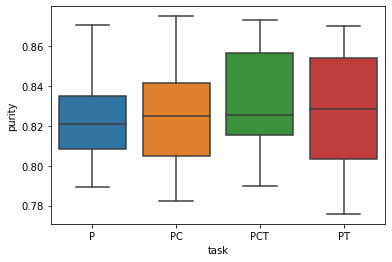

In [13]:
import seaborn as sns
task_purity = pd.DataFrame.from_dict(task_purity)
sns.boxplot(data=task_purity, x="task", y="purity")

In [14]:
from scipy.stats import kruskal
P_purity = task_purity[task_purity.task == 'P'].purity.to_list()
PC_purity = task_purity[task_purity.task == 'PC'].purity.to_list()
PCT_purity = task_purity[task_purity.task == 'PCT'].purity.to_list()
PT_purity = task_purity[task_purity.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.10707217558504323, pvalue=0.7435023649785497)
P vs PCT: KruskalResult(statistic=3.1876286937148532, pvalue=0.07419756925486769)
P vs PT: KruskalResult(statistic=0.9921424551859903, pvalue=0.31921930291522976)
PC vs PCT: KruskalResult(statistic=2.0570947689420342, pvalue=0.1514987745326073)
PC vs PT: KruskalResult(statistic=0.4283339000739055, pvalue=0.5128076125054786)
PCT vs PT: KruskalResult(statistic=0.231562903036712, pvalue=0.6303673732611186)


In [10]:
def compute_silhouette_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(word_type_counts['abstract'])
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    return metrics.silhouette_score(emb_matrix, true_labels)

task_sil = {'task':[], 
               'sil':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_sil = task_models.groupby("model").apply(lambda x: compute_silhouette_balance_data(x))
    print('mean:', model_sil.mean())
    print('std:', model_sil.std())
    task_sil['sil'].extend(model_sil.tolist())
    task_sil['task'].extend([task]*len(model_sil))

Task: P
mean: 0.05118804520715856
std: 0.007769818897053615
Task: PC
mean: 0.05183455340327488
std: 0.006104136577515038
Task: PCT
mean: 0.055948097229136885
std: 0.00710479440293303
Task: PT
mean: 0.05124026348388774
std: 0.008781108931046793


In [12]:
from scipy.stats import kruskal
task_sil = pd.DataFrame.from_dict(task_sil)
P_sil = task_sil[task_sil.task == 'P'].sil.to_list()
PC_sil = task_sil[task_sil.task == 'PC'].sil.to_list()
PCT_sil = task_sil[task_sil.task == 'PCT'].sil.to_list()
PT_sil = task_sil[task_sil.task == 'PT'].sil.to_list()
print("P vs PC:", kruskal(P_sil, PC_sil))
print("P vs PCT:", kruskal(P_sil, PCT_sil))
print("P vs PT:", kruskal(P_sil, PT_sil))
print("PC vs PCT:", kruskal(PC_sil, PCT_sil))
print("PC vs PT:", kruskal(PC_sil, PT_sil))
print("PCT vs PT:", kruskal(PCT_sil, PT_sil))

P vs PC: KruskalResult(statistic=0.25037037037040477, pvalue=0.6168144089718366)
P vs PCT: KruskalResult(statistic=8.277870370370351, pvalue=0.0040131170266547705)
P vs PT: KruskalResult(statistic=0.03703703703703809, pvalue=0.8473896596867122)
PC vs PCT: KruskalResult(statistic=7.104537037037062, pvalue=0.007688908140766365)
PC vs PT: KruskalResult(statistic=0.548981481481519, pvalue=0.4587341591017978)
PCT vs PT: KruskalResult(statistic=7.5737037037037, pvalue=0.005922595857839187)


In [15]:
# Affinity propagation clustering
def compute_purity_balance_data_aff_prop(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    aff_prop = AffinityPropagation().fit(emb_matrix)
    y_pred = aff_prop.labels_
    #print('emb_matrix:', emb_matrix.shape)
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_aff_prop = {'task':[], 
                        'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_aff_prop(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_aff_prop['purity'].extend(model_purity.tolist())
    task_purity_aff_prop['task'].extend([task]*len(model_purity))

Task: P


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8899425287356323
std: 0.006595990405191766
Task: PC


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8911079182630907
std: 0.0070975459007081255
Task: PCT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8909642401021711
std: 0.007167561350424478
Task: PT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8873403575989782
std: 0.007429911596267459


In [16]:
from scipy.stats import kruskal
task_purity_aff_prop = pd.DataFrame.from_dict(task_purity_aff_prop)
P_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'P'].purity.to_list()
PC_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PC'].purity.to_list()
PCT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PCT'].purity.to_list()
PT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.528854668232564, pvalue=0.46708877909445345)
P vs PCT: KruskalResult(statistic=0.3175337373594828, pvalue=0.5730935616693535)
P vs PT: KruskalResult(statistic=4.011709332488272, pvalue=0.04518531842577633)
PC vs PCT: KruskalResult(statistic=0.10409748966746357, pvalue=0.746966816845346)
PC vs PT: KruskalResult(statistic=5.587127141516109, pvalue=0.018092946741692328)
PCT vs PT: KruskalResult(statistic=5.319114177387579, pvalue=0.02109273136104282)


In [17]:
# Agglomerative (hierarchical) clustering
def compute_purity_balance_data_agglomerative(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    agg = AgglomerativeClustering(n_clusters=None,
                                  metric='cosine',
                                  linkage='average',
                                 distance_threshold=0.5).fit(emb_matrix)
    y_pred = agg.labels_
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_agg = {'task':[], 
                   'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_agglomerative(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_agg['purity'].extend(model_purity.tolist())
    task_purity_agg['task'].extend([task]*len(model_purity))

Task: P
mean: 0.9322477650063856
std: 0.012556565012527995
Task: PC
mean: 0.9306673052362708
std: 0.01357608936407527
Task: PCT
mean: 0.9277618135376755
std: 0.014827165720076908
Task: PT
mean: 0.9289750957854406
std: 0.013540307094867336


In [18]:
from scipy.stats import kruskal
task_purity_agg = pd.DataFrame.from_dict(task_purity_agg)
P_purity = task_purity_agg[task_purity_agg.task == 'P'].purity.to_list()
PC_purity = task_purity_agg[task_purity_agg.task == 'PC'].purity.to_list()
PCT_purity = task_purity_agg[task_purity_agg.task == 'PCT'].purity.to_list()
PT_purity = task_purity_agg[task_purity_aff_prop.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.31726172315056383, pvalue=0.5732579147007723)
P vs PCT: KruskalResult(statistic=1.9890404490691072, pvalue=0.15844124500367154)
P vs PT: KruskalResult(statistic=1.4135708000938394, pvalue=0.23446452343773186)
PC vs PCT: KruskalResult(statistic=1.0022685418694899, pvalue=0.3167622090626746)
PC vs PT: KruskalResult(statistic=0.42844944874504903, pvalue=0.512750762509105)
PCT vs PT: KruskalResult(statistic=0.12341868264594963, pvalue=0.7253558292854259)
